In [ ]:
### INFX575 Group Project: Preliminary data analysis

In [1]:
#0.  Setup
# Numpy for working with Arrays
import numpy as np
# Pandas for working with data tables
import pandas as pd
# SciPy implements many different numerical algorithms
import scipy as sp
import scipy.stats as stats
# Module for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Module for pretty plotting
#import seaborn as sns
# Module for linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Pump it Up: Data Mining the Water Table 
Team members: Anya, Ashwin, Brett, Wenhong  

Hosted by DrivenData.org    
Source: https://www.drivendata.org/competitions/7/

---

## Preliminary Data Analysis

### Loading data
DrivenData.org provided 3 datasets:  
1. Training set values - the independent variables for the training set  
2. Training set labels - the dependent variable for the training set
3. Test set values - the independent variables that need prediction

We merged dataset \#1 and \#2 into pandas dataframe named 'water'.  'Water' will be used throughout the project as the data for machine learning purposes.  After the preliminary analysis, we will split 'water' into a training set for training algorithms and a validation set for testing the performance of our predictions (unseen during training phase).  In the final stage, we will use dataset \#3 as the actual testing set for making actual predictions and submit our results to DrivenData.org as part of the competition.

In [2]:
### load data from csv files
water_values = pd.read_csv('../train_set_values.csv')
water_labels = pd.read_csv('../train_set_labels.csv')

In [26]:
### merge values and labels
water = pd.merge(water_values, water_labels, on='id')
# set date_recorded to date/time
water['date_recorded'] = pd.to_datetime(water['date_recorded'])
print "Merged dataset dimensions: ", water.shape[0], "observations, ", water.shape[1], "variables"
#preview merged data
water.head()

Merged dataset dimensions:  59400 observations,  41 variables


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,...,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,...,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,...,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,...,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,...,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,...,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### 1. What information/features/characteristics do you have for each observation? 
'Water' dataset include numeric and non-numeric variables.

In [27]:
print "All numeric variables: \n", list(water.select_dtypes(include=[np.number]).columns.values)
print "\nAll non-numeric variables: \n", list(water.select_dtypes(exclude=[np.number]).columns.values)

All numeric variables: 
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

All non-numeric variables: 
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


Response variable: 'status_group' - categorical data with 3 possible values:
- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

Predictor variables: we will evaluate all the other features and determine which should be used as input variables.

Summary of numeric features:  
- id - metadata, a uniqued identifier of each waterpoint
- amount_tsh - quantitative, total static head (or amount water available to waterpoint)
- gps_height, longitude, latitude - geographical 3D coordinates
- num_private - no description provided, values range from 0 to 1776
- region_code, district_code - categorical, region and district codes of Tanzania
- population - quantitative, population around the well, units not specified
- construction_year - quantitative, year the waterpoint was constructed, range from 1960 to 2013 

-Summary of non-numeric features: 
- wpt_name - name of waterpoint, if exists, 'none' if doesn't
- waterpoint_type, waterpoint_type_group - categorical, the kind of waterpoint, i.e. 'communal standpipe', most redundant values
- date_recorded - metadata, row entered date
- recorded_by - metadata, group entering data, all values equal 'GeoData Consultants Ltd.'
- funder, installer - categorical, organizations that created the well
- basin, region, lga, ward, subvillage - categorical, geographical locations, hierarchical order
- public_meeting, permit - boolean True/False
- extraction_type_class, extraction_type_group, extraction_type - categorical, kind of extraction, hierarchical order
- scheme_management, scheme_name - categorical, who operates the waterpoint, hierarchical order
- management_group, management - categorical, how the waterpoint is managed (note: 'management' and 'scheme_management' many redundant values)
- payment, payment_type - categorical, payment arrangements, note: most redundant values
- water_quality, quality_group - categorical, the quality of water, note: most redundant values
- quantity, quantity_group - categorical, the quantity of water, note: all redundant values
- source_class - categorical, the source of water, values: 'groundwater', 'surface', 'unknown'
- source_type, source - categorical, the source of water, most redundant values

Refer to Appendix A for the list of features for each waterpoint as provided by DrivenData.org at https://www.drivendata.org/competitions/7/page/25/#features_list.

### 2. What are the min/max/mean/median/sd values for each of these features? What is the distribution of the core features (show a histogram)?
#### 2.1 Min/max/mean/median/sd
We determined the following features to be numeric and appropriate for min/max/mean/sd: 'id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'construction_year'. However numeric featuers 'region_code'and 'district_code' were removed from this table because they are categorical and not suitable for this analysis.

In [28]:
# Exclude year', 'folnum', 'village' from list of columns
cols = [col for col in water.columns if col not in ['date_recorded', 'funder', 'installer', 'wpt_name',\
                                                   'basin', 'subvillage', 'region', 'region_code', \
                                                   'district_code', 'lga', 'ward', 'public_meeting', \
                                                   'recorded_by', 'scheme_management', 'scheme_name', \
                                                   'permit', 'extraction_type', \
                                                    'extraction_type_group', 'extraction_type_class', \
                                                    'management', 'management_group', 'payment','payment_type', \
                                                    'water_quality', 'quality_group', 'quantity', \
                                                   'quantity_group', 'source', 'source_type', 'source_class', \
                                                   'waterpoint_type', 'waterpoint_type_group', 'status_group']]

# Get the mean and standard deviation for selected variables
summary = water[cols].describe().transpose()
#[['mean', 'std', 'min', 'max']]

# Give name to column that has the list of variables 
summary.index.names = ['variable']

# Move the index into the columns
summary.reset_index(inplace=True, drop=False)

# Sort the result by the name of variables alphabetically
summary.sort_values(by='variable', ascending=1, inplace=True)

# Sort the index
summary=summary.reset_index()
#[['variable','mean','std']]

summary

,index,variable,count,mean,std,min,25%,50%,75%,max
0,1,amount_tsh,59400.0,317.650385,2997.574558,0.00000,0.000000,0.000000,20.000000,3.500000e+05
1,7,construction_year,59400.0,1300.652475,951.620547,0.00000,0.000000,1986.000000,2004.000000,2.013000e+03
2,2,gps_height,59400.0,668.297239,693.116350,-90.00000,0.000000,369.000000,1319.250000,2.770000e+03
3,0,id,59400.0,37115.131768,21453.128371,0.00000,18519.750000,37061.500000,55656.500000,7.424700e+04
4,4,latitude,59400.0,-5.706033,2.946019,-11.64944,-8.540621,-5.021597,-3.326156,-2.000000e-08
5,3,longitude,59400.0,34.077427,6.567432,0.00000,33.090347,34.908743,37.178387,4.034519e+01
6,5,num_private,59400.0,0.474141,12.236230,0.00000,0.000000,0.000000,0.000000,1.776000e+03
7,6,population,59400.0,179.909983,471.482176,0.00000,0.000000,25.000000,215.000000,3.050000e+04


#### 2.2 Categorical feature distributions
First, the label (functional, functional needs repair, and nonfunctional) distribution:

In [29]:
# label counts
water['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

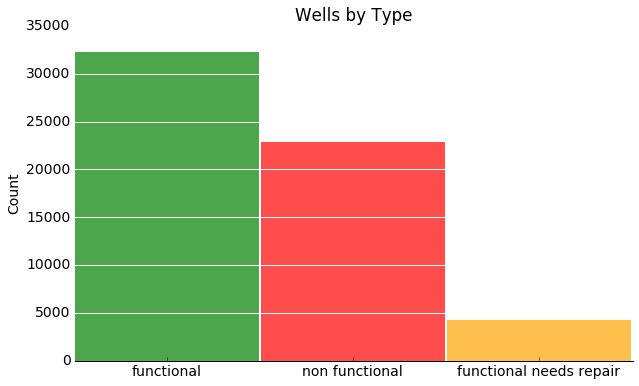

In [30]:
%matplotlib inline 

# set some nicer defaults for matplotlib (from: Raza Khan, INFX 574 University of Washington, 2016)
from matplotlib import rcParams

# Some code below to produce pretty graphs
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

# make function to remove borders/ticks
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

# define style
def histogram_style():
    remove_border(left=False)
    plt.grid(False)
    plt.grid(axis='y', color='w', linestyle='-', lw=1)
    

# make df to hold Status_group counts
label_counts = pd.DataFrame(water.status_group.value_counts())

# set plot parameters
ind = np.arange(label_counts.index.size)
width = .99

# create plot
plt.bar(ind, label_counts.values, width = width, color = ['green', 'red', 'orange'], alpha = .7)

# add labels
plt.gca().set_ylabel('Count')
plt.gca().set_title('Wells by Type')
plt.xticks(ind + width/2., label_counts.index)

    
histogram_style()

Next, we look at the distributions of each of the categorical features. Note that features with > 50 categories are ommitted, because the resulting plots are not informative.

In [31]:
# create df of only categorical data (type = 'object') for making histograms below
obj_columns = pd.DataFrame()

# only include object type columns with between 2 and 50 unique values (exclude ones with 
# too many categories because histogram becomes useless)
for c in water:
    if water[c].dtypes == 'O':
        if (len(water[c].unique()) > 1) and (len(water[c].unique())) < 50:
            obj_columns[c] = water[c]

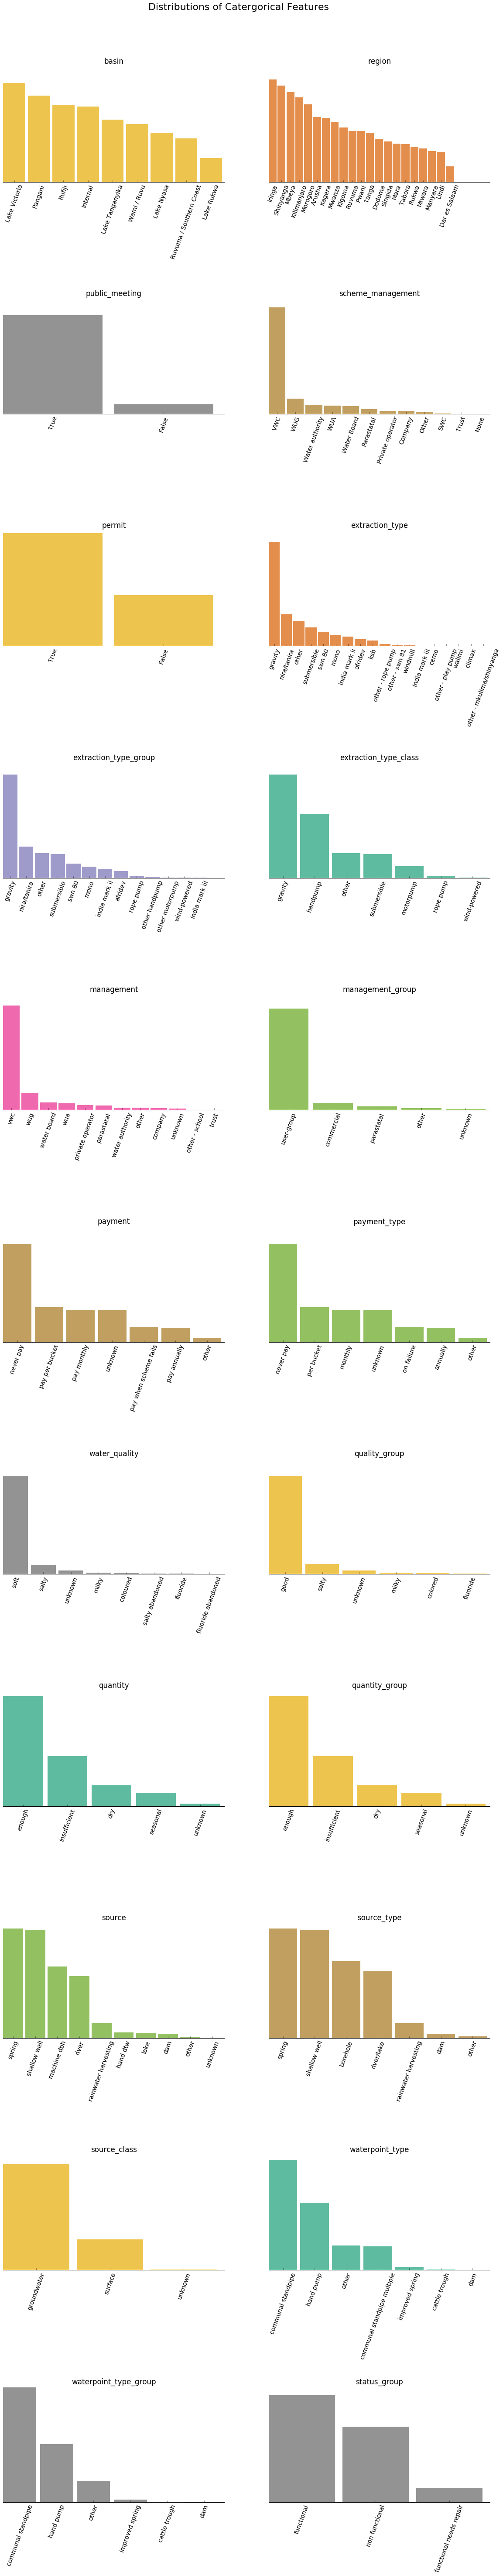

In [33]:
from random import randint

# set up figure with 22 subplots
fig, axs = plt.subplots(11,2, figsize=(20,100))
axs = axs.ravel()

# set spacing between subplots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

# give title
fig.suptitle('Distributions of Catergorical Features', fontsize=22, y=.92)

# define style function
def sub_histogram_style(axs):
    remove_border(left=False, axes = axs) # pass subplot object 'axs'
    axs.grid(False)
    axs.grid(axis='y', color='w', linestyle='-', lw=1)

# initialize counter
i = 0
# iterate for loop to create each subplot out of column from obj_columns df
for c in obj_columns:

    # make df to hold Status_group counts
    feature_count = pd.DataFrame(water[c].value_counts())

    # set plot parameters
    ind = np.arange(feature_count.index.size)
    width = .9

    # create plot
    axs[i].bar(ind, feature_count.values, width = width, color = dark2_colors[randint(0,7)], alpha = .7)
    axs[i].set_title(c) # title
    plt.sca(axs[i]) # apply next command to specific plot (sca must be used for plt.xticks to work)
    plt.xticks(ind + width/2., feature_count.index, rotation = 70) # x axis labels, rotated
    axs[i].get_yaxis().set_visible(False) # remove y axis
    
    sub_histogram_style(axs[i]) # apply style function to subplot
    i += 1



### 3. Are there obvious trends in the data (over time, across subgroups, etc.), and are the differences statistically significant?

#### 3.1 Explore temporal trends
We used 'construction_year' variable to see status of waterpoints over time.  

Excluded  20709  records with construction year = 0


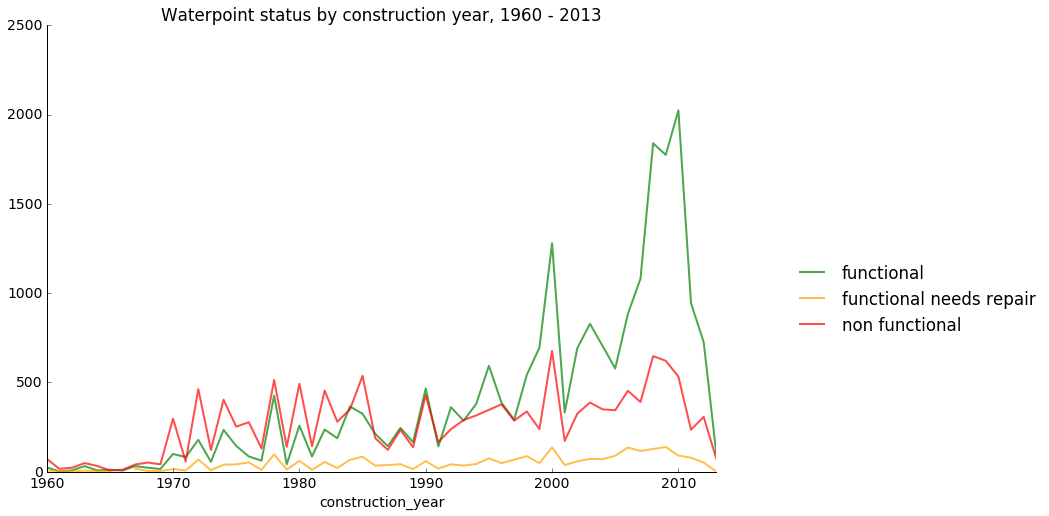

In [24]:
print "Excluded ", len(water[water.construction_year==0]), " records with construction year = 0"

# draw status by year
water_temporal = water[water.construction_year!=0].groupby('construction_year').status_group.value_counts()
plt.rc('figure', figsize=(12, 8))
g=water_temporal.unstack().plot(color=['g','orange','r'], alpha=.7, title = "Waterpoint status by construction year, 1960 - 2013")
plt.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
remove_border()

This plot captures trends over time: all three lines have ups and downs between 1960 and 2013.  Green line wih functional waterpoints shows the greatest variability, with a couple of significant spikes;  a major donwfall by 2013 could be due to report timing - it's possible data collection is incomplete for the year 2013. Red line with non-functional systems still varies a lot but less than green.  Yellow line with semi-functional wells shows the least variability.  We also notice more broken wells before 1985, and the situation improving around 1990s with funcitional systems exceeding broken ones.

#### 3.2 Explore regional data
Regional information is represented by a few geographical variables: 'basin', 'region', 'lga', 'ward', and 'subvillage'.  'Basin' is the highest level of the regional hierarchy (and it comes with no missing data).  

In [ ]:
#draw status by basin
water_region_grouped = water.groupby('basin').status_group.value_counts()
water_region_grouped.unstack().plot(kind='bar', color=['g','orange','r'], alpha=.6, title = "Waterpoint status by region, 1960 - 2013")

This plot summarizes each basin by status.  All except two basins show more functional wells than non-functional. If we wanted more granularity, we could drill down the regional hierarchy and group data by field 'region'.   


#### 3.3. Observe statistical influence through Pearson's correlation.

We looked at the correlation between numerical variables to observe influence of one over other variables. The variables used to acquire the correlation matrix are amount_tsh, construction_year, district_code, gps_height, latitude, longitude, population, and region_code.

In [ ]:
# creating data frames for variables with numerical data and 
water_int = water.loc[:,water.dtypes[water.dtypes=="int64"].index]
water_float = water.loc[:,water.dtypes[water.dtypes=="float64"].index]

# merging int and float data frames in water_numerical
water_numerical = pd.concat([water_int, water_float], axis=1)

# excluding columns 'id' and 'num_private' for correlation matrix
water_corrplot = water_numerical.loc[:,water_numerical.columns-['id','num_private']]

# generating correlation matrix for the numerical data frame
corr = water_corrplot.corr()

# initializing figure and axes objects to set figure size
f1, ax1 = plt.subplots(figsize=(18, 9))
# generating heatmap using the correlation matrix we acquired above
sns.heatmap(corr, vmax=.3, square=True, linewidths=.8, annot=True)

ax1.set_title("Pearson's Correlation Heatmap", fontsize=15)

In [ ]:
construction_gpsheight = water.loc[:,['construction_year', 'gps_height']].query(
    'construction_year>0 and gps_height>0').corr().iloc[0,1]

print "Correlation between construction_year and gps_height excluding zeros: %f" %(construction_gpsheight)

One of our concerns about the data is the number of "0" values we have for every numerical variable. However, a preliminary test to acquire the correlation between variables indicates that there is no evident pattern of influence other than for geographical coordinate variables. Both 'construction_year' and 'gps_height' have large number of zeros for values. The correlation between those two variables excluding zeros is *-0.004436*.

We will also be making a decision on how to treat the "0" values in our next steps.

#### 3.4. Scatter plots to observe patterns/trends

Here we have made a scatter plot matrix for meaningful numerical variables.

In [ ]:
sns.set(style="white")
sns.pairplot(water, vars={'amount_tsh','construction_year','gps_height','latitude', 'longitude','population'},
             hue="status_group")

We are able to see high density at 0 for the variables. Although we are not able to see any direct trends, we can see that there are more functional water pumps in high population areas, as expected. Also as the available water increases, we see a steady increase in the population.

### 4. What are the other salient aspects of the data (e.g. geospatial factors, text content, etc.)

In [ ]:
### Wenhong code ###

### 5. Provide a bullet-list of the next 5-10 tasks you will perform in analyzing your dataset.

* Check for null/missing values
* Determine appropriate handling of null/missing/zero values for each feature (imputation, row removal, categorical constant)
* Look for correlation between features, and compress/remove/combine if appropriate
* Tidy the data so it is ready for machine learning algorithms


## Appendix A.  DataDriven.org Documentation

### List of features for each observation
- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint



### Extra - post some interesting code but delete before submission

In [ ]:
### anya sharing - i like using lambda :)
# explore categorical data, specifically by unique values
#findings: 
#   high cardinality data is hard to eye-ball
#   max to consider probably region with 21

water_categorical = water.select_dtypes(exclude=[np.number])
print "All non-numeric columns: ", water_categorical.columns.values

#number of unique values in each category
### look at each variable count of unique values
water_unique = water_categorical.apply(lambda x: len(x.unique()))
print water_unique.sort_values()